In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import urllib3

# Evitar warnings SSL si usás verify=False
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


## ¿Qué es una API?

Una **API** (del inglés, **Application Programming Interface**) es un conjunto de reglas y protocolos que permite que diferentes aplicaciones de software se comuniquen entre sí. Piensa en una API como un "menú" que ofrece un restaurante. En lugar de cocinar todo desde cero, solo pides un plato (envías una solicitud a la API) y el chef (el servidor de la API) te lo prepara y entrega (te devuelve una respuesta).

En tu caso, la API del Banco Central de la República Argentina (**BCRA**) es el "restaurante" que te permite solicitar datos financieros como el tipo de cambio, las reservas, y otros indicadores, sin necesidad de acceder a una base de datos directamente.

### ¿Qué es una petición HTTP?

Una **petición HTTP** es la forma en que tu programa (el "cliente") le pide información a un servidor. Es como si enviaras una nota con tu orden al "restaurante". Esta petición incluye:

* **URL:** La dirección específica del recurso que quieres obtener (ej: `https://api.bcra.gob.ar/estadisticas/v3.0/monetarias`).
* **Verbo HTTP:** El tipo de acción que quieres realizar. Los más comunes son:
    * **GET:** Para solicitar o leer datos. Es el que usas en tu código para "obtener" información. 📥
    * **POST:** Para enviar datos nuevos al servidor.
    * **PUT/PATCH:** Para actualizar datos existentes.
    * **DELETE:** Para eliminar datos.

---

## ¿Qué es NoSQL?

**NoSQL** (del inglés, **Not Only SQL**) es un tipo de base de datos que, a diferencia de las bases de datos relacionales tradicionales (que usan tablas y SQL), ofrece un almacenamiento más flexible. Se usan mucho para datos no estructurados o semiestructurados, como documentos JSON (que es lo que la API del BCRA te devuelve).

En tu código, cuando haces la petición `requests.get()`, la respuesta que obtienes es un archivo en formato **JSON** (**JavaScript Object Notation**). Este formato es perfecto para NoSQL porque organiza los datos en pares de `clave: valor` (como los que ves en la respuesta de la API), lo que lo hace muy fácil de leer y manipular en diferentes lenguajes de programación como Python.

---

## ¿Qué es un certificado SSL?

Un certificado **SSL** (**Secure Sockets Layer**) es un archivo digital que cifra la comunicación entre tu navegador (o tu script de Python) y un servidor web. Su función principal es garantizar que la información que se envía (como contraseñas, datos financieros, etc.) no pueda ser interceptada o leída por terceros.

Cuando ves una URL que comienza con `https://`, la "s" significa "seguro" y te indica que la conexión está protegida por un certificado SSL. En tu script, la opción `verify=False` le indica a la librería `requests` que omita la verificación de este certificado. Esto es útil para casos de prueba o si tienes problemas de conexión, pero en un entorno de producción, siempre es recomendable verificar el certificado para asegurar una conexión segura.


## Estadisticas BCRA
La API de Estadísticas monetarias proporciona acceso a recursos relacionados con la información de Series.xlsm y principales variables publicadas por el BCRA. A continuación, se describen los endpoints disponibles.

https://www.bcra.gob.ar/BCRAyVos/catalogo-de-APIs-banco-central.asp

In [2]:
url = "https://api.bcra.gob.ar/estadisticas/v3.0/monetarias"
headers = {"Accept-Language": "es-AR"}

# Omitir la verificación del certificado SSL
response = requests.get(url, headers=headers, verify=False)

if response.status_code == 200:
    data = response.json()
    for variable in data['results'][:3]:
        print(f"- {variable['descripcion']} ({variable['fecha']}): {variable['valor']}")
else:
    print("Error:", response.status_code)

- Reservas Internacionales del BCRA (en millones de dólares - cifras provisorias sujetas a cambio de valuación) (2025-09-11): 40365.0
- Tipo de Cambio Minorista ($ por USD) Comunicación B 9791 - Promedio vendedor (2025-09-15): 1479.81
- Tipo de Cambio Mayorista ($ por USD) Comunicación A 3500 - Referencia (2025-09-15): 1462.0


- Reservas Internacionales del BCRA (en millones de dólares - cifras provisorias sujetas a cambio de valuación) (2025-07-21): 40652.0
- Tipo de Cambio Minorista ($ por USD) Comunicación B 9791 - Promedio vendedor (2025-07-23): 1277.43
- Tipo de Cambio Mayorista ($ por USD) Comunicación A 3500 - Referencia (2025-07-23): 1259.67

5 - Tipo de Cambio Mayorista ($ por USD) Comunicación A 3500 - Referencia


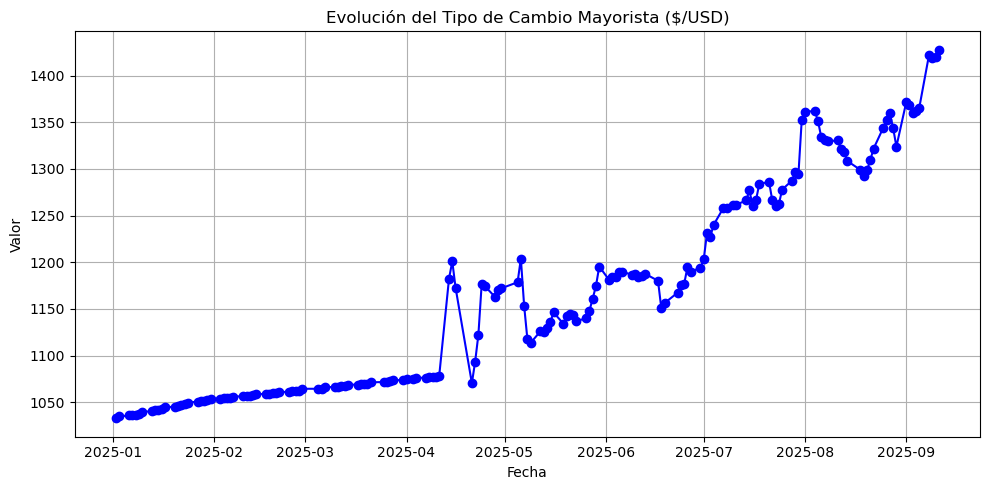

In [4]:
# Paso 1: Obtener todas las variables para buscar el ID
url_base = "https://api.bcra.gob.ar/estadisticas/v3.0/monetarias"
response = requests.get(url_base, headers={"Accept-Language": "es-AR"}, verify=False)
variables = response.json()['results']

#Imprimimos las variables para ver qué hay
#print(variables)
# Buscar el ID del tipo de cambio mayorista en las variables. Con el fin filtras el nombre asi no buscas interminablemente
for v in variables:
    if "mayorista" in v['descripcion'].lower():
        print(f"{v['idVariable']} - {v['descripcion']}")

# El id de la variable es 5
id_variable = 5

# Paso 2: Descargar datos históricos (últimos 6 meses, por ejemplo)
desde = "2025-01-01"
hasta = "2025-09-11"

# importante ver cómo se construye la url, id_variable, desde y hasta son los parametros que modifican la url.
url_data = f"https://api.bcra.gob.ar/estadisticas/v3.0/monetarias/{id_variable}?desde={desde}&hasta={hasta}"

# guardas en data lo obtenido
response = requests.get(url_data, verify=False)
data = response.json()["results"]

# Paso 3: Convertir a DataFrame (Acá entra la parte de pandas que importamos como pd y que iremos estudiando)
df = pd.DataFrame(data)
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

# Paso 4: Graficamos con matplotlib
plt.figure(figsize=(10, 5))
plt.plot(df['fecha'], df['valor'], marker='o', linestyle='-', color='blue')
plt.title('Evolución del Tipo de Cambio Mayorista ($/USD)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()
plt.show()